# Random Forest CHALLENGE

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split, GridSearchCV
import math, time
import ds_useful as ds

[My Useful Data Science Functions](https://github.com/cobyoram/python-for-data-scientists/blob/master/ds_useful.py)

In [203]:
try:
    raw_solar = pd.read_csv('energy_dataset.csv')
    raw_weather = pd.read_csv('weather_features.csv')
except FileNotFoundError as e:
    print(e)
    print('Attempting to read datasets from online csv files on Github')
    raw_solar = pd.read_csv('https://github.com/cobyoram/Thinkful_capstone_1/blob/master/energy_dataset.csv')
    raw_weather = pd.read_csv('https://github.com/cobyoram/Thinkful_capstone_1/blob/master/weather_features.csv')

This is the pair of datasets I used for my first capstone. Since I think I am going to use it for my second capstone, I figured it'd be worth implementing into this challeng. This time, I want to try to predict the solar production based off of just weather information.

In [204]:
raw_solar.columns

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual'],
      dtype='object')

In [205]:
raw_solar[['generation solar', 'forecast solar day ahead']]

generation solar  forecast solar day ahead
0                  49.0                      17.0
1                  50.0                      16.0
2                  50.0                       8.0
3                  50.0                       2.0
4                  42.0                       9.0
...                 ...                       ...
35059              85.0                      96.0
35060              33.0                      51.0
35061              31.0                      36.0
35062              31.0                      29.0
35063              31.0                      26.0

[35064 rows x 2 columns]

In [206]:
raw_weather.columns

Index(['dt_iso', 'city_name', 'temp', 'temp_min', 'temp_max', 'pressure',
       'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h',
       'clouds_all', 'weather_id', 'weather_main', 'weather_description',
       'weather_icon'],
      dtype='object')

In [207]:
raw_weather.head()

dt_iso city_name     temp  temp_min  temp_max  pressure  \
0  2015-01-01 00:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
1  2015-01-01 01:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
2  2015-01-01 02:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
3  2015-01-01 03:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
4  2015-01-01 04:00:00+01:00  Valencia  269.686   269.686   269.686      1002   

   humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
0        77           1        62      0.0      0.0      0.0           0   
1        77           1        62      0.0      0.0      0.0           0   
2        78           0        23      0.0      0.0      0.0           0   
3        78           0        23      0.0      0.0      0.0           0   
4        78           0        23      0.0      0.0      0.0           0   

   weather_id weather_main weather_description weather_icon  
0         800        clear        sky is clear          01n  
1         800        clear        sky is clear          01n  
2         800        clear        sky is clear          01n  
3         800        clear        sky is clear          01n  
4         800        clear        sky is clear          01n

In [208]:
for col in raw_weather.select_dtypes('object').columns:
    print(col, raw_weather[col].unique(), '\n')

dt_iso ['2015-01-01 00:00:00+01:00' '2015-01-01 01:00:00+01:00'
 '2015-01-01 02:00:00+01:00' ... '2018-12-31 21:00:00+01:00'
 '2018-12-31 22:00:00+01:00' '2018-12-31 23:00:00+01:00'] 

city_name ['Valencia' 'Madrid' 'Bilbao' ' Barcelona' 'Seville'] 

weather_main ['clear' 'clouds' 'rain' 'mist' 'thunderstorm' 'drizzle' 'fog' 'smoke'
 'haze' 'snow' 'dust' 'squall'] 

weather_description ['sky is clear' 'few clouds' 'scattered clouds' 'broken clouds'
 'overcast clouds' 'light rain' 'moderate rain' 'heavy intensity rain'
 'mist' 'heavy intensity shower rain' 'shower rain' 'very heavy rain'
 'thunderstorm with heavy rain' 'thunderstorm with light rain'
 'thunderstorm with rain' 'proximity thunderstorm' 'thunderstorm'
 'light intensity shower rain' 'light intensity drizzle' 'fog' 'drizzle'
 'smoke' 'heavy intensity drizzle' 'haze' 'proximity shower rain'
 'light intensity drizzle rain' 'light snow' 'rain and snow'
 'light rain and snow' 'snow' 'light thunderstorm' 'heavy snow' 'sleet'
 'rai

In [209]:
raw_weather.describe()

temp       temp_min       temp_max      pressure  \
count  178396.000000  178396.000000  178396.000000  1.783960e+05   
mean      289.618605     288.330442     291.091267  1.069261e+03   
std         8.026199       7.955491       8.612454  5.969632e+03   
min       262.240000     262.240000     262.240000  0.000000e+00   
25%       283.670000     282.483602     284.650000  1.013000e+03   
50%       289.150000     288.150000     290.150000  1.018000e+03   
75%       295.150000     293.730125     297.150000  1.022000e+03   
max       315.600000     315.150000     321.150000  1.008371e+06   

            humidity    wind_speed       wind_deg        rain_1h  \
count  178396.000000  178396.00000  178396.000000  178396.000000   
mean       68.423457       2.47056     166.591190       0.075492   
std        21.902888       2.09591     116.611927       0.398847   
min         0.000000       0.00000       0.000000       0.000000   
25%        53.000000       1.00000      55.000000       0.000000   
50%        72.000000       2.00000     177.000000       0.000000   
75%        87.000000       4.00000     270.000000       0.000000   
max       100.000000     133.00000     360.000000      12.000000   

             rain_3h        snow_3h     clouds_all     weather_id  
count  178396.000000  178396.000000  178396.000000  178396.000000  
mean        0.000380       0.004763      25.073292     759.831902  
std         0.007288       0.222604      30.774129     108.733223  
min         0.000000       0.000000       0.000000     200.000000  
25%         0.000000       0.000000       0.000000     800.000000  
50%         0.000000       0.000000      20.000000     800.000000  
75%         0.000000       0.000000      40.000000     801.000000  
max         2.315000      21.500000     100.000000     804.000000

In [210]:
ds.missingness_summary(raw_weather)

weather_icon           0.0
wind_speed             0.0
city_name              0.0
temp                   0.0
temp_min               0.0
temp_max               0.0
pressure               0.0
humidity               0.0
wind_deg               0.0
weather_description    0.0
rain_1h                0.0
rain_3h                0.0
snow_3h                0.0
clouds_all             0.0
weather_id             0.0
weather_main           0.0
dt_iso                 0.0
dtype: float64

In [211]:
raw_solar.loc[raw_solar['generation solar'].isnull()]

time  generation biomass  \
99     2015-01-05 03:00:00+01:00                 NaN   
108    2015-01-05 12:00:00+01:00                 NaN   
109    2015-01-05 13:00:00+01:00                 NaN   
110    2015-01-05 14:00:00+01:00                 NaN   
111    2015-01-05 15:00:00+01:00                 NaN   
112    2015-01-05 16:00:00+01:00                 NaN   
113    2015-01-05 17:00:00+01:00                 NaN   
451    2015-01-19 19:00:00+01:00                 NaN   
452    2015-01-19 20:00:00+01:00                 NaN   
643    2015-01-27 19:00:00+01:00                 NaN   
661    2015-01-28 13:00:00+01:00                 NaN   
2528   2015-04-16 09:00:00+02:00                 NaN   
2708   2015-04-23 21:00:00+02:00                 NaN   
3968   2015-06-15 09:00:00+02:00                 NaN   
6586   2015-10-02 11:00:00+02:00                 NaN   
8049   2015-12-02 09:00:00+01:00                 NaN   
13341  2016-07-09 22:00:00+02:00                 NaN   
30896  2018-07-11 09:00:00+02:00                 NaN   

       generation fossil brown coal/lignite  \
99                                      NaN   
108                                     NaN   
109                                     NaN   
110                                     NaN   
111                                     NaN   
112                                     NaN   
113                                     NaN   
451                                     NaN   
452                                     NaN   
643                                     NaN   
661                                     NaN   
2528                                    NaN   
2708                                    NaN   
3968                                    NaN   
6586                                    NaN   
8049                                    NaN   
13341                                   NaN   
30896                                   NaN   

       generation fossil coal-derived gas  generation fossil gas  \
99                                    NaN                    NaN   
108                                   NaN                    NaN   
109                                   NaN                    NaN   
110                                   NaN                    NaN   
111                                   NaN                    NaN   
112                                   NaN                    NaN   
113                                   NaN                    NaN   
451                                   NaN                    NaN   
452                                   NaN                    NaN   
643                                   NaN                    NaN   
661                                   NaN                    NaN   
2528                                  NaN                    NaN   
2708                                  NaN                    NaN   
3968                                  NaN                    NaN   
6586                                  NaN                    NaN   
8049                                  NaN                    NaN   
13341                                 NaN                    NaN   
30896                                 NaN                    NaN   

       generation fossil hard coal  generation fossil oil  \
99                             NaN                    NaN   
108                            NaN                    NaN   
109                            NaN                    NaN   
110                            NaN                    NaN   
111                            NaN                    NaN   
112                            NaN                    NaN   
113                            NaN                    NaN   
451                            NaN                    NaN   
452                            NaN                    NaN   
643                            NaN                    NaN   
661                            NaN                    NaN   
2528                           NaN          

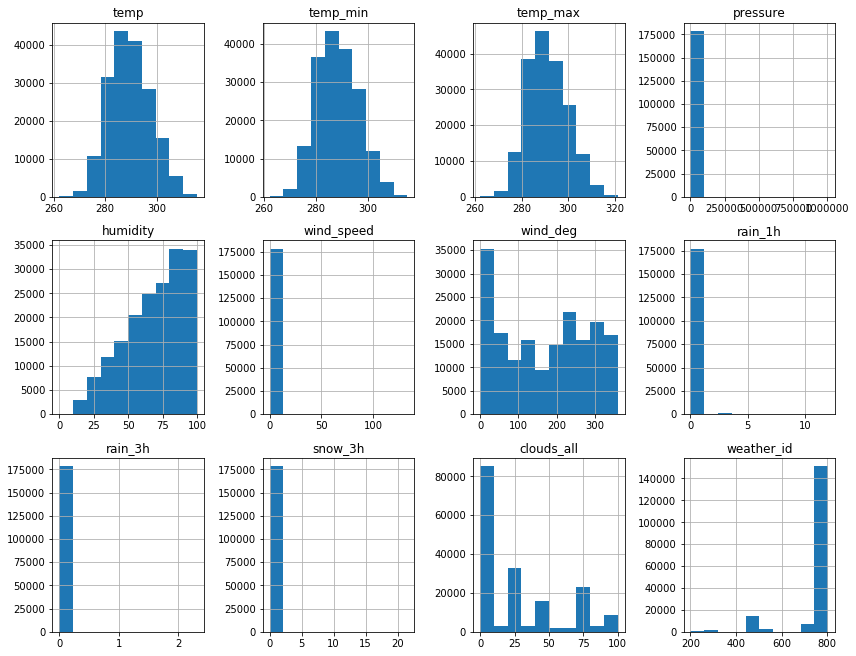

In [212]:
def plot_num(df, column_name):
    df[column_name].hist()

ds.make_subplots(raw_weather.select_dtypes('number'), plot_num)

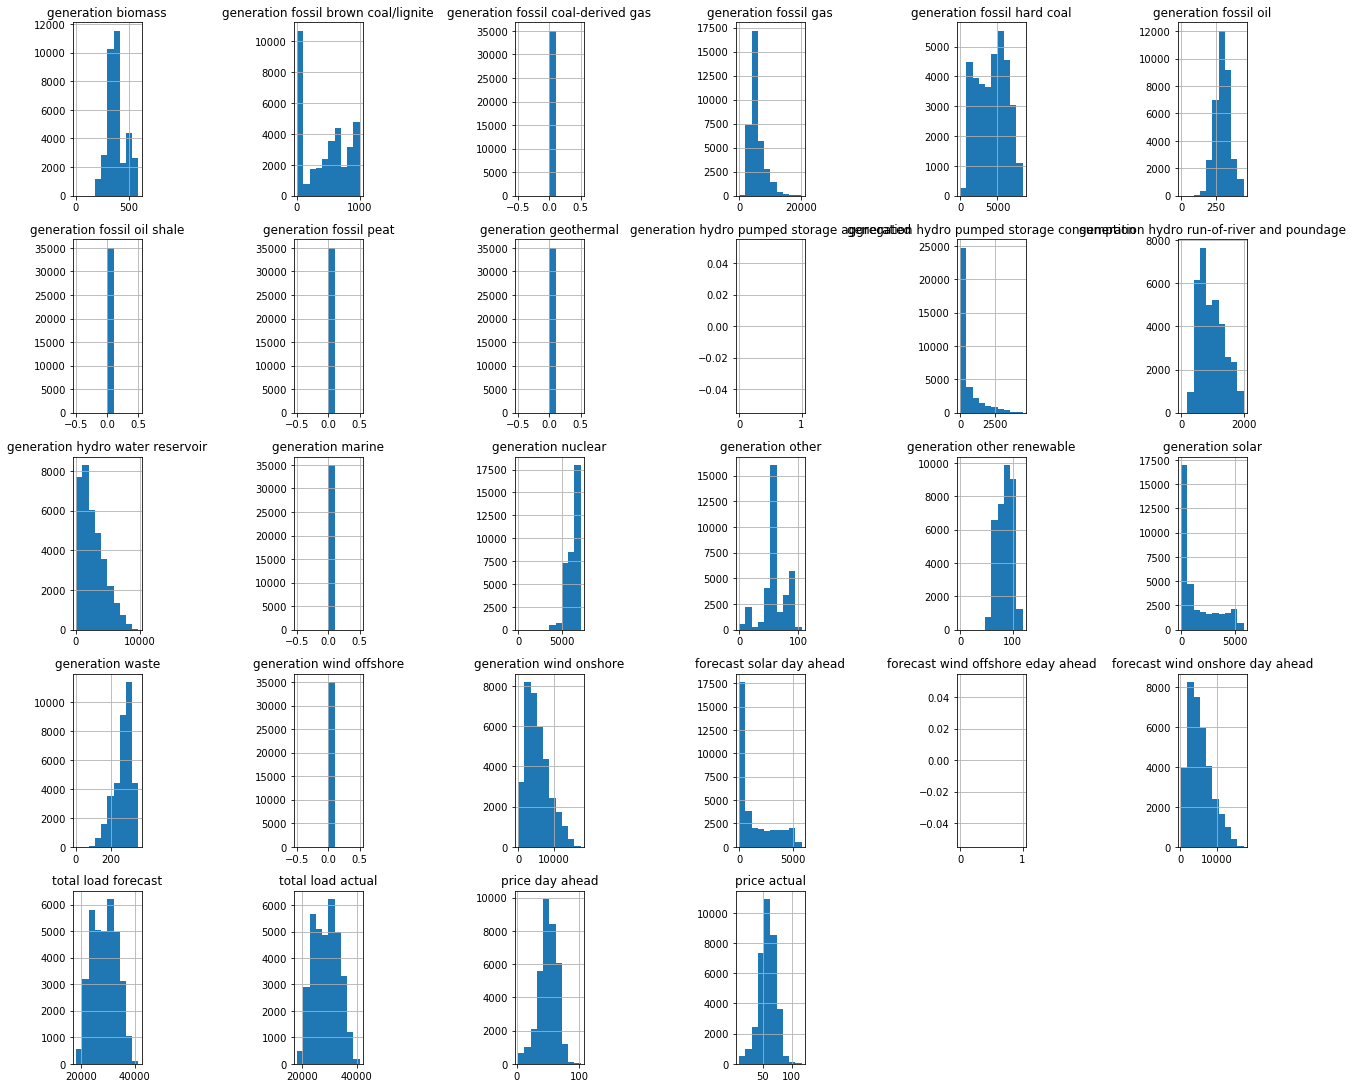

In [213]:
ds.make_subplots(raw_solar.select_dtypes('number'), plot_num)

First we'll grab just our target variable from the energy dataset. We want to predict the solar production at any hour using weather data, so we only need the 'generation solar' and 'time' columns ('time' will be used to join the datasets together)

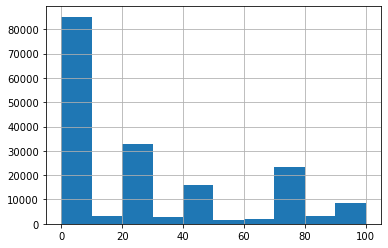

In [214]:
raw_weather['clouds_all'].hist()

In [215]:
# The data is provided in the correct timezone, but we want to centralize the data on the local timezone
# We drop the '+##:##' from each timestamp reading in both datasets 
raw_weather['dt_iso'] = raw_weather['dt_iso'].str.replace('\+[0-9][0-9]:[0-9][0-9]', '', regex=True)
raw_solar['time'] = raw_solar['time'].str.replace('\+[0-9][0-9]:[0-9][0-9]', '', regex=True)

raw_weather = raw_weather.rename({'dt_iso': 'time'}, axis=1)

In [216]:
# Make a new dataframe with just solar generation and time
time_solar = raw_solar[['time', 'generation solar']]

# Inputate the missing data for solar generation
time_solar = time_solar.interpolate()
ds.missingness_summary(time_solar)

generation solar    0.0
time                0.0
dtype: float64

In [217]:
# Add the solar data to the weather dataset
solar_weather = raw_weather.merge(time_solar, on='time')
solar_weather['time'] = pd.to_datetime(solar_weather['time'])

In [218]:
solar_weather

time   city_name        temp    temp_min    temp_max  \
0      2015-01-01 00:00:00    Valencia  270.475000  270.475000  270.475000   
1      2015-01-01 00:00:00      Madrid  267.325000  267.325000  267.325000   
2      2015-01-01 00:00:00      Bilbao  269.657312  269.657312  269.657312   
3      2015-01-01 00:00:00   Barcelona  281.625000  281.625000  281.625000   
4      2015-01-01 00:00:00     Seville  273.375000  273.375000  273.375000   
...                    ...         ...         ...         ...         ...   
178431 2018-12-31 23:00:00    Valencia  279.140000  278.150000  280.150000   
178432 2018-12-31 23:00:00      Madrid  275.150000  275.150000  275.150000   
178433 2018-12-31 23:00:00      Bilbao  275.600000  275.150000  276.150000   
178434 2018-12-31 23:00:00   Barcelona  280.130000  277.150000  283.150000   
178435 2018-12-31 23:00:00     Seville  283.970000  282.150000  285.150000   

        pressure  humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  \
0           1001        77           1        62      0.0      0.0      0.0   
1            971        63           1       309      0.0      0.0      0.0   
2           1036        97           0       226      0.0      0.0      0.0   
3           1035       100           7        58      0.0      0.0      0.0   
4           1039        75           1        21      0.0      0.0      0.0   
...          ...       ...         ...       ...      ...      ...      ...   
178431      1029        75           2       300      0.0      0.0      0.0   
178432      1031        74           1       360      0.0      0.0      0.0   
178433      1034        93           2       100      0.0      0.0      0.0   
178434      1028       100           5       310      0.0      0.0      0.0   
178435      1029        70           3        50      0.0      0.0      0.0   

        clouds_all  weather_id weather_main weather_description weather_icon  \
0                0         800        clear        sky is clear          01n   
1                0         800        clear        sky is clear          01n   
2                0         800        clear        sky is clear           01   
3                0         800        clear        sky is clear          01n   
4                0         800        clear        sky is clear          01n   
...            ...         ...          ...                 ...          ...   
178431           0         800        clear        sky is clear          01n   
178432           0         800        clear        sky is clear          01n   
178433           0         800        clear        sky is clear          01n   
178434           0         800        clear        sky is clear          01n   
178435           0         800        clear        sky is clear          01n   

        generation solar  
0                   49.0  
1                   49.0  
2                   49.0  
3                   49.0  
4                   49.0  
...                  ...  
178431              31.0  
178432              31.0  
178433              31.0  
178434              31.0  
178435              31.0  

[178436 rows x 18 columns]

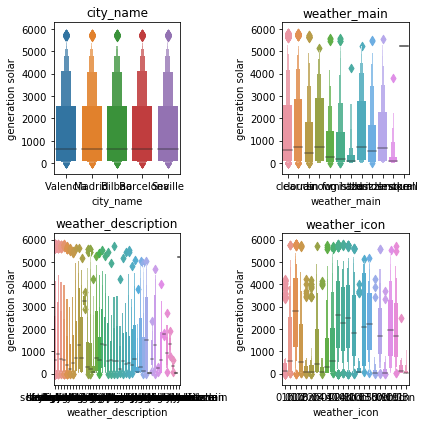

In [219]:
def plot_cat(df, col, target):
    sns.boxenplot(x=col, y=target, data=df)
    
ds.make_subplots(solar_weather.drop('time', axis=1).select_dtypes('object'), plot_cat, [solar_weather['generation solar']])

In [220]:
drop_cols = ['weather_description', 'weather_icon', 'weather_id']

solar_weather.drop(drop_cols, axis=1, inplace=True)

In [221]:
solar_weather.head()

time   city_name        temp    temp_min    temp_max  pressure  \
0 2015-01-01    Valencia  270.475000  270.475000  270.475000      1001   
1 2015-01-01      Madrid  267.325000  267.325000  267.325000       971   
2 2015-01-01      Bilbao  269.657312  269.657312  269.657312      1036   
3 2015-01-01   Barcelona  281.625000  281.625000  281.625000      1035   
4 2015-01-01     Seville  273.375000  273.375000  273.375000      1039   

   humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
0        77           1        62      0.0      0.0      0.0           0   
1        63           1       309      0.0      0.0      0.0           0   
2        97           0       226      0.0      0.0      0.0           0   
3       100           7        58      0.0      0.0      0.0           0   
4        75           1        21      0.0      0.0      0.0           0   

  weather_main  generation solar  
0        clear              49.0  
1        clear              49.0  
2        clear              49.0  
3        clear              49.0  
4        clear              49.0

In [222]:
outliers = ds.outliers_summary(solar_weather)
outliers

rain_1h             10.867762
pressure             6.635432
wind_speed           1.359031
rain_3h              1.039588
temp_max             0.219126
temp_min             0.162523
snow_3h              0.149633
temp                 0.109843
humidity             0.035307
generation solar     0.000000
clouds_all           0.000000
wind_deg             0.000000
dtype: float64

In [223]:
# Look at the min and max for each column with outliers
meaningless_columns = []
for col in outliers.loc[outliers>0].index:
    min_val, max_val = ds.get_minmax_with_threshold(solar_weather[col], 1.5)
    print(col, min_val, max_val)
    if min_val == max_val:
        meaningless_columns.append(col)

rain_1h 0.0 0.0
pressure 999.5 1035.5
wind_speed -3.5 8.5
rain_3h 0.0 0.0
temp_max 265.9 315.9
temp_min 265.6245 310.5804999999999
snow_3h 0.0 0.0
temp 266.45000000000005 312.3699999999999
humidity 2.0 138.0


In [224]:
# Drop columns with all meaningful data outside the min and max
solar_weather.drop(meaningless_columns, axis=1, inplace=True)
solar_weather.head()

time   city_name        temp    temp_min    temp_max  pressure  \
0 2015-01-01    Valencia  270.475000  270.475000  270.475000      1001   
1 2015-01-01      Madrid  267.325000  267.325000  267.325000       971   
2 2015-01-01      Bilbao  269.657312  269.657312  269.657312      1036   
3 2015-01-01   Barcelona  281.625000  281.625000  281.625000      1035   
4 2015-01-01     Seville  273.375000  273.375000  273.375000      1039   

   humidity  wind_speed  wind_deg  clouds_all weather_main  generation solar  
0        77           1        62           0        clear              49.0  
1        63           1       309           0        clear              49.0  
2        97           0       226           0        clear              49.0  
3       100           7        58           0        clear              49.0  
4        75           1        21           0        clear              49.0

In [225]:
outliers = ds.outliers_summary(solar_weather)
outliers

pressure            6.635432
wind_speed          1.359031
temp_max            0.219126
temp_min            0.162523
temp                0.109843
humidity            0.035307
generation solar    0.000000
clouds_all          0.000000
wind_deg            0.000000
dtype: float64

In [226]:
# Since we have a time-series, we will winsorize the outliers to keep them in the dataset.
for col in outliers.loc[outliers>0].index:
    percentiles = ds.get_percentiles(solar_weather, col, 1.5)
    stats.mstats.winsorize(solar_weather[col], percentiles, axis=0, inplace=True)
    
ds.outliers_summary(solar_weather)

generation solar    0.0
clouds_all          0.0
wind_deg            0.0
wind_speed          0.0
humidity            0.0
pressure            0.0
temp_max            0.0
temp_min            0.0
temp                0.0
dtype: float64

In [227]:
# make dummy variables for
dummies = pd.get_dummies(solar_weather.select_dtypes('object'), drop_first=True)
dummies.head()

city_name_Bilbao  city_name_Madrid  city_name_Seville  city_name_Valencia  \
0                 0                 0                  0                   1   
1                 0                 1                  0                   0   
2                 1                 0                  0                   0   
3                 0                 0                  0                   0   
4                 0                 0                  1                   0   

   weather_main_clouds  weather_main_drizzle  weather_main_dust  \
0                    0                     0                  0   
1                    0                     0                  0   
2                    0                     0                  0   
3                    0                     0                  0   
4                    0                     0                  0   

   weather_main_fog  weather_main_haze  weather_main_mist  weather_main_rain  \
0                 0                  0                  0                  0   
1                 0                  0                  0                  0   
2                 0                  0                  0                  0   
3                 0                  0                  0                  0   
4                 0                  0                  0                  0   

   weather_main_smoke  weather_main_snow  weather_main_squall  \
0                   0                  0                    0   
1                   0                  0                    0   
2                   0                  0                    0   
3                   0                  0                    0   
4                   0                  0                    0   

   weather_main_thunderstorm  
0                          0  
1                          0  
2                          0  
3                          0  
4                          0

In [228]:
sw_feat = pd.concat([dummies, solar_weather.drop(['city_name', 'weather_main', 'time'], axis=1)], axis=1)
sw_feat.head()

city_name_Bilbao  city_name_Madrid  city_name_Seville  city_name_Valencia  \
0                 0                 0                  0                   1   
1                 0                 1                  0                   0   
2                 1                 0                  0                   0   
3                 0                 0                  0                   0   
4                 0                 0                  1                   0   

   weather_main_clouds  weather_main_drizzle  weather_main_dust  \
0                    0                     0                  0   
1                    0                     0                  0   
2                    0                     0                  0   
3                    0                     0                  0   
4                    0                     0                  0   

   weather_main_fog  weather_main_haze  weather_main_mist  ...  \
0                 0                  0                  0  ...   
1                 0                  0                  0  ...   
2                 0                  0                  0  ...   
3                 0                  0                  0  ...   
4                 0                  0                  0  ...   

   weather_main_thunderstorm        temp    temp_min    temp_max  pressure  \
0                          0  270.475000  270.475000  270.475000      1001   
1                          0  267.325000  267.325000  267.325000      1000   
2                          0  269.657312  269.657312  269.657312      1035   
3                          0  281.625000  281.625000  281.625000      1035   
4                          0  273.375000  273.375000  273.375000      1035   

   humidity  wind_speed  wind_deg  clouds_all  generation solar  
0        77           1        62           0              49.0  
1        63           1       309           0              49.0  
2        97           0       226           0              49.0  
3       100           7        58           0              49.0  
4        75           1        21           0              49.0  

[5 rows x 24 columns]

In [229]:
correlated_cols = ds.similar_variables(sw_feat, 'generation solar')
sw_feat.drop(correlated_cols.index, axis=1, inplace=True)

In [230]:
# Join the numerical data back to the dummies
X = sw_feat.drop('generation solar', axis=1)
y = sw_feat['generation solar']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.1)
X

city_name_Bilbao  city_name_Madrid  city_name_Seville  \
0                      0                 0                  0   
1                      0                 1                  0   
2                      1                 0                  0   
3                      0                 0                  0   
4                      0                 0                  1   
...                  ...               ...                ...   
178431                 0                 0                  0   
178432                 0                 1                  0   
178433                 1                 0                  0   
178434                 0                 0                  0   
178435                 0                 0                  1   

        city_name_Valencia  weather_main_clouds  weather_main_drizzle  \
0                        1                    0                     0   
1                        0                    0                     0   
2                        0                    0                     0   
3                        0                    0                     0   
4                        0                    0                     0   
...                    ...                  ...                   ...   
178431                   1                    0                     0   
178432                   0                    0                     0   
178433                   0                    0                     0   
178434                   0                    0                     0   
178435                   0                    0                     0   

        weather_main_dust  weather_main_fog  weather_main_haze  \
0                       0                 0                  0   
1                       0                 0                  0   
2                       0                 0                  0   
3                       0                 0                  0   
4                       0                 0                  0   
...                   ...               ...                ...   
178431                  0                 0                  0   
178432                  0                 0                  0   
178433                  0                 0                  0   
178434                  0                 0                  0   
178435                  0                 0                  0   

        weather_main_mist  ...  weather_main_smoke  weather_main_snow  \
0                       0  ...                   0                  0   
1                       0  ...                   0                  0   
2                       0  ...                   0                  0   
3                       0  ...                   0                  0   
4                       0  ...                   0                  0   
...                   ...  ...                 ...                ...   
178431                  0  ...                   0                  0   
178432                  0  ...                   0                  0   
178433                  0  ...                   0                  0   
178434                  0  ...                   0                  0   
178435                  0  ...                   0                  0   

        weather_main_squall  weather_main_thunderstorm        temp  pressure  \
0                         0                          0  270.475000      1001   
1                         0                          0  267.325000      1000   
2                         0                          0  269.657312      1035   
3                         0                          0  281.625000      1035   
4                         0                          0  273.375000      1035   
...                     ...                        ...         ...       ...   
178431                    0                          0  279.140000      1029   
178432                    0             

In [231]:
from sklearn.linear_model import LinearRegression

lrm = LinearRegression()
lrm.fit(X_train, y_train)
lrm.score(X_test, y_test)

0.2351147102926164

In [232]:
import statsmodels.api as sm

lrm_sm = sm.OLS(y_train, sm.add_constant(X_train))
result = lrm_sm.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       generation solar   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     2307.
Date:                Tue, 25 Feb 2020   Prob (F-statistic):               0.00
Time:                        23:35:52   Log-Likelihood:            -1.3989e+06
No. Observations:              160592   AIC:                         2.798e+06
Df Residuals:                  160570   BIC:                         2.798e+06
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -3.005e+04    555.326    -54.119      0.000   -3.11e+04    -2.9e+04
city_name_Bilbao            190.5395     12.213     15.601      0.000     166.602     214.477
city_name_Madrid           -218.3261     12.519    -17.440      0.000    -242.862    -193.790
city_name_Seville          -377.6029     12.105    -31.193      0.000    -401.329    -353.876
city_name_Valencia         -242.5996     11.857    -20.460      0.000    -265.840    -219.359
weather_main_clouds         190.6656     11.629     16.395      0.000     167.872     213.459
weather_main_drizzle        448.6701     40.259     11.145      0.000     369.763     527.577
weather_main_dust           -67.7741     84.004     -0.807      0.420    -232.420      96.871
weather_main_fog            424.1854     32.923     12.884      0.000     359.658     488.713
weather_main_haze          -586.2155     74.172     -7.903      0.000    -731.591    -440.840
weather_main_mist           377.3813     27.645     13.651      0.000     323.197     431.566
weather_main_rain           321.2563     18.624     17.250      0.000     284.753     357.759
weather_main_smoke         -842.7020    268.319     -3.141      0.002   -1368.601    -316.803
weather_main_snow          1223.8943     95.585     12.804      0.000    1036.549    1411.240
weather_main_squall        2657.7022   1468.925      1.809      0.070    -221.360    5536.765
weather_main_thunderstorm    21.2163     49.534      0.428      0.668     -75.870     118.302
temp                         51.7386      0.601     86.062      0.000      50.560      52.917
pressure                     17.8874      0.492     36.371      0.000      16.924      18.851
humidity                    -25.3747      0.246   -103.211      0.000     -25.857     -24.893
wind_speed                   50.0360      2.152     23.255      0.000      45.819      54.253
wind_deg                     -0.9044      0.033    -27.402      0.000      -0.969      -0.840
clouds_all                    2.8610      0.203     14.076      0.000       2.463       3.259
==============================================================================
Omnibus:                    12304.890   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15378.870
Skew:                           0.757   Prob(JB):                         0.00
Kurtosis:                       2.923   Cond. No.                     4.30e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.3e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

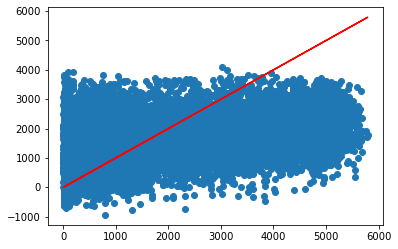

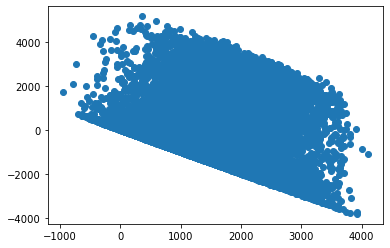

In [233]:
y_pred = lrm.predict(X_test)
plt.scatter(y_test, y_pred)
plt.plot(y_test, y_test, 'r')
plt.show()

residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.show()

In [234]:
sq_y = y_train**3

sq_model = sm.OLS(sq_y, sm.add_constant(X_train))
results = sq_model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       generation solar   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     1503.
Date:                Tue, 25 Feb 2020   Prob (F-statistic):               0.00
Time:                        23:36:00   Log-Likelihood:            -4.1275e+06
No. Observations:              160592   AIC:                         8.255e+06
Df Residuals:                  160570   BIC:                         8.255e+06
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -6.183e+11   1.33e+10    -46.537      0.000   -6.44e+11   -5.92e+11
city_name_Bilbao           3.967e+09   2.92e+08     13.578      0.000    3.39e+09    4.54e+09
city_name_Madrid          -4.073e+09      3e+08    -13.600      0.000   -4.66e+09   -3.49e+09
city_name_Seville         -7.707e+09    2.9e+08    -26.611      0.000   -8.27e+09   -7.14e+09
city_name_Valencia        -4.561e+09   2.84e+08    -16.077      0.000   -5.12e+09      -4e+09
weather_main_clouds        2.517e+09   2.78e+08      9.045      0.000    1.97e+09    3.06e+09
weather_main_drizzle       7.438e+09   9.63e+08      7.722      0.000    5.55e+09    9.33e+09
weather_main_dust         -5.032e+09   2.01e+09     -2.504      0.012   -8.97e+09   -1.09e+09
weather_main_fog           5.504e+09   7.88e+08      6.988      0.000    3.96e+09    7.05e+09
weather_main_haze         -9.447e+09   1.77e+09     -5.324      0.000   -1.29e+10   -5.97e+09
weather_main_mist          6.084e+09   6.61e+08      9.199      0.000    4.79e+09    7.38e+09
weather_main_rain          4.951e+09   4.46e+08     11.111      0.000    4.08e+09    5.82e+09
weather_main_smoke        -1.525e+10   6.42e+09     -2.376      0.017   -2.78e+10   -2.67e+09
weather_main_snow          2.198e+10   2.29e+09      9.612      0.000    1.75e+10    2.65e+10
weather_main_squall        1.013e+11   3.51e+10      2.882      0.004    3.24e+10     1.7e+11
weather_main_thunderstorm -3.442e+09   1.19e+09     -2.904      0.004   -5.76e+09   -1.12e+09
temp                       1.089e+09   1.44e+07     75.725      0.000    1.06e+09    1.12e+09
pressure                   3.491e+08   1.18e+07     29.674      0.000    3.26e+08    3.72e+08
humidity                  -4.669e+08   5.88e+06    -79.371      0.000   -4.78e+08   -4.55e+08
wind_speed                 6.152e+08   5.15e+07     11.951      0.000    5.14e+08    7.16e+08
wind_deg                  -1.582e+07    7.9e+05    -20.034      0.000   -1.74e+07   -1.43e+07
clouds_all                   5.1e+07   4.86e+06     10.489      0.000    4.15e+07    6.05e+07
==============================================================================
Omnibus:                    52405.127   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           147788.546
Skew:                           1.757   Prob(JB):                         0.00
Kurtosis:                       6.121   Cond. No.                     4.30e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.3e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

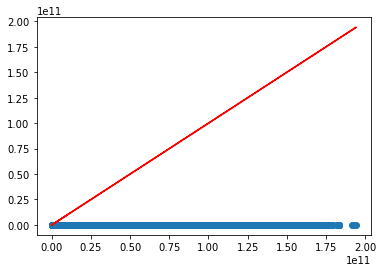

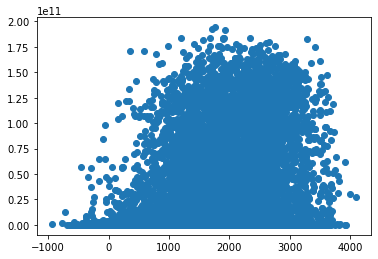

In [237]:
y_sq_test = y_test**3
y_pred = lrm.predict(X_test)
plt.scatter(y_sq_test, y_pred)
plt.plot(y_sq_test, y_sq_test, 'r')
plt.show()

residuals = y_sq_test - y_pred
plt.scatter(y_pred, residuals)
plt.show()

In [236]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors = 7)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.2733444052046521